## Twitter sentiment analyser example

### *Guillermo Climent*

In [1]:
import re

import numpy as np
import pandas as pd

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn import model_selection
from sklearn.pipeline import Pipeline

from textblob import TextBlob

from pymongo import MongoClient

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='white')

from PIL import Image

from stop_words import get_stop_words
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

### 1. Utility classes

In [2]:
class TextPreprocesser(object):
    def __init__(self):
        pass

    def clean_text(self, text):
        ''' Utility function to clean text by removing links, special
        characters using simple regex statements.
        '''
        return ' '.join(
            re.sub(
                '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)', ' ', text
            ).split()
        )


class SentimentAnalyser(TextPreprocesser):
    def __init__(self):
        pass

    def get_sentiment(self, text):
        ''' Utility function to classify sentiment of passed text using
        textblob's sentiment method
        '''
        # Create TextBlob object of passed text
        analysis = TextBlob(self.clean_text(text))

        # Set sentiment
        if analysis.sentiment.polarity > 0:
            return 'positive'
        elif analysis.sentiment.polarity == 0:
            return 'neutral'
        else:
            return 'negative'

### 2. Getting the data

Data has already been downloaded using the Twitter API and the CustomListener class defined in listener.py script. The keyword was Brexit and the first idea was to analyse the sentiment of tweets coming from the UK versus tweets coming from the rest of the EU.

In [3]:
client = MongoClient('localhost', port=27017)
db = client['tweets']

collections_dict = dict()

for region in ['uk', 'eu']:
    collection = db['{}_brexit'.format(region)]

    res = collection.find({}, {'_id': False})
    res = list(res[:])
    
    collections_dict[region] = res

## 3. Sentiment analysis

#### 3.1 Extract sentiments

In [4]:
analyser = SentimentAnalyser()

tweets_dict = dict()
sentiments_dict = dict()

for region in ['uk', 'eu']:
    res = collections_dict[region]
    
    clean_tweets = [analyser.clean_text(tweet['text']) for tweet in res]
    tweets_dict[region] = clean_tweets
    
    sentiments = [analyser.get_sentiment(tweet) for tweet in clean_tweets]
    sentiments_counter = Counter(sentiments)
    
    sentiments_dict[region] = sentiments_counter

#### 3.2. Plot sentiment count

In [5]:
# Sort keys for the barplot palette
key_order = ['positive', 'neutral', 'negative']

sentiments_df = pd.DataFrame()

for region in ['uk', 'eu']:
    sentiments_counter = sentiments_dict[region]
    sentiments_counter = {k : sentiments_counter[k] for k in key_order}

    # Sentiment plot
    new_df = pd.DataFrame({
        'Sentiment': list(sentiments_counter.keys()),
        'Count': list(sentiments_counter.values()),
        'Region': region.upper()
    })
    sentiments_df = pd.concat([sentiments_df, new_df], axis=0)

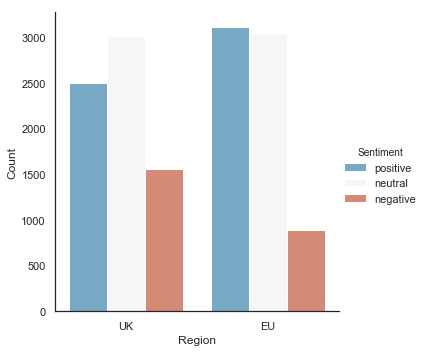

In [6]:
ax = sns.catplot(
    x='Region', y='Count', hue='Sentiment',
    data=sentiments_df, kind='bar', palette='RdBu_r'
)

## 4. Wordcloud

In [7]:
def plot_wordcloud(text, stopwords, mask):
    wordcloud = WordCloud(
        background_color='white',
        max_words=500,
        mask=mask,
        stopwords=stopwords,
        width=1600,
        height=1200
    ).generate(' '.join(text))
    
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

#### 4.1. Define stop words

In [8]:
stop_words = list(get_stop_words('en'))       # About 900 stopwords
nltk_words = list(stopwords.words('english')) # About 150 stopwords
custom_words = ['brexit', 'eu', 'uk', 'rt']

final_stop_words = list(STOPWORDS) + stop_words + nltk_words + custom_words

#### 4.2. Plot wordcloud

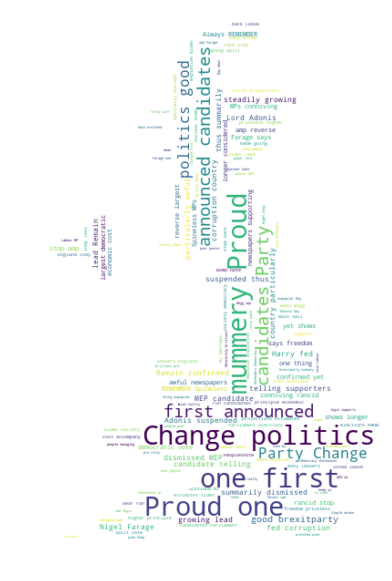

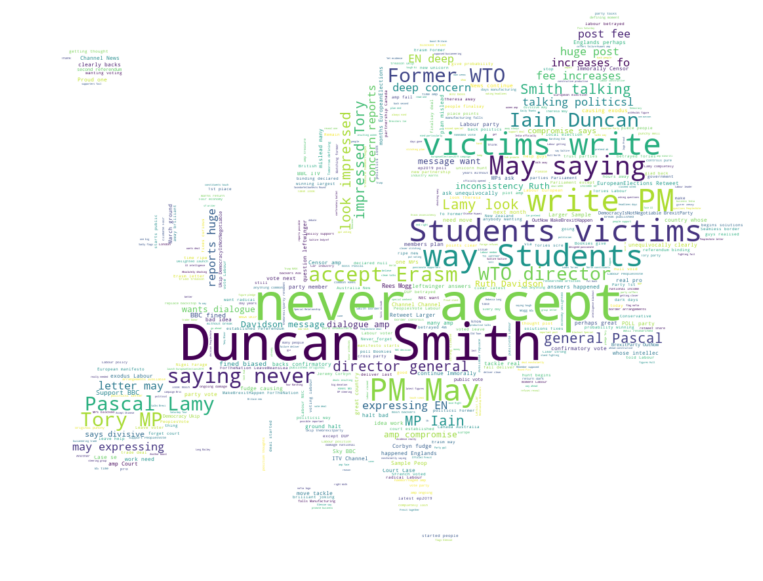

In [9]:
for region in ['uk', 'eu']:
    clean_tweets = tweets_dict[region]
    
    final_tweets = []
    for sentence in clean_tweets:
        final_tweets.extend(sentence.split())

    mask = np.array(Image.open('img/{}.png'.format(region)))
    
    plot_wordcloud(final_tweets, stopwords=final_stop_words, mask=mask)

The differences between both regions are clearly observed in the maps. On one hand, the UK map shows the concern of local people about their politics and candidates, while the map of Europe shows a landscape of several pro-Bexit politicians, such as Ducan Smith, former Conservative party leader. The latter map also shows the concern of European people for the students, protrayed as victims of the process.